### DEEP LEARNING

## **TEXT SUMMARIZATION MODEL**
## **BART FINE TUNING MODEL**

In [35]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BartTokenizer, BartForConditionalGeneration, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import rouge_score
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set random seeds and device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [36]:
train_df = pd.read_csv('../data/train.csv', header=None)
test_df = pd.read_csv('../data/test.csv', header=None)
val_df = pd.read_csv('../data/validation.csv', header=None)

columns = ['id', 'article', 'summary']
train_df.columns = columns
test_df.columns = columns
val_df.columns = columns

def preprocess_text(text):
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())
    return text

def clean_article_heading(article):
    pattern = r'By\s*\.\s*.*?\s*\.\s*PUBLISHED:\s*\.\s*\d+:\d+\s*EST,\s*\d+\s*[A-Za-z]+\s*\d+\s*\.\s*\|\s*\.\s*UPDATED:\s*\.\s*\d+:\d+\s*EST,\s*\d+\s*[A-Za-z]+\s*\d+\s*\.'
    cleaned_text = re.sub(pattern, '', article)
    return cleaned_text.strip()

train_df['article'] = train_df['article'].apply(preprocess_text)
train_df['article'] = train_df['article'].apply(clean_article_heading)
train_df['summary'] = train_df['summary'].apply(preprocess_text)
test_df['article'] = test_df['article'].apply(preprocess_text)
test_df['article'] = test_df['article'].apply(clean_article_heading)
test_df['summary'] = test_df['summary'].apply(preprocess_text)
val_df['article'] = val_df['article'].apply(preprocess_text)
val_df['article'] = val_df['article'].apply(clean_article_heading)
val_df['summary'] = val_df['summary'].apply(preprocess_text)

print(f"Training dataframe shape: {train_df.shape}")
print(f"Test dataframe shape: {test_df.shape}")
print(f"Validation dataframe shape: {val_df.shape}")

Training dataframe shape: (287114, 3)
Test dataframe shape: (11491, 3)
Validation dataframe shape: (13369, 3)


In [37]:
class TextPreprocessor:
    """Text preprocessing utilities for news articles."""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def clean_text(self, text):
        """Clean and normalize text."""
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    
    def remove_stopwords(self, text):
        """Remove stopwords from text."""
        words = word_tokenize(text)
        filtered_words = [word for word in words if word not in self.stop_words]
        return ' '.join(filtered_words)
    
    def preprocess(self, text, remove_stopwords=False):
        """Apply all preprocessing steps."""
        text = self.clean_text(text)
        if remove_stopwords:
            text = self.remove_stopwords(text)
        return text
    
    # Initialize preprocessor
 # preprocessor = TextPreprocessor()

""" train_df['article'] = train_df['article'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))
train_df['summary'] = train_df['summary'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))

val_df['article'] = val_df['article'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))
val_df['summary'] = val_df['summary'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))

test_df['article'] = test_df['article'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))
test_df['summary'] = test_df['summary'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False)) """

" train_df['article'] = train_df['article'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))\ntrain_df['summary'] = train_df['summary'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))\n\nval_df['article'] = val_df['article'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))\nval_df['summary'] = val_df['summary'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))\n\ntest_df['article'] = test_df['article'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False))\ntest_df['summary'] = test_df['summary'].apply(lambda x: preprocessor.preprocess(x, remove_stopwords=False)) "

In [38]:
print(train_df['id'].iloc[1])
print(train_df['article'].iloc[1])
print(train_df['summary'].iloc[1])
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

0001d1afc246a7964130f43ae940af6bc6c57f01
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepatitis A include fever, ti

In [39]:
train_df = train_df.sample(n=20000, random_state=42)
test_df = test_df.sample(n=2000, random_state=42)
val_df = val_df.sample(n=2000, random_state=42)

In [40]:
class NewsDataset(Dataset):
    def __init__(self, articles, summaries, tokenizer, max_length=512):
        self.articles = articles
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.articles)
    
    def __getitem__(self, idx):
        article = str(self.articles[idx])
        summary = str(self.summaries[idx])
        
        article_encoding = self.tokenizer(
            article,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        summary_encoding = self.tokenizer(
            summary,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'article_input_ids': article_encoding['input_ids'].flatten(),
            'article_attention_mask': article_encoding['attention_mask'].flatten(),
            'summary_input_ids': summary_encoding['input_ids'].flatten(),
            'summary_attention_mask': summary_encoding['attention_mask'].flatten()
        }

### **BART BASE**

**DATA LOADER CREATION**

In [41]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

train_dataset = NewsDataset(
    train_df['article'].values,
    train_df['summary'].values,
    tokenizer
)

val_dataset = NewsDataset(
    val_df['article'].values,
    val_df['summary'].values,
    tokenizer
)

test_dataset = NewsDataset(
    test_df['article'].values,
    test_df['summary'].values,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

**MODEL AND TRAINING DEFINITION**

In [42]:
class SummarizationModel(nn.Module):
    """BART-based summarization model."""
    
    def __init__(self, model_name='facebook/bart-base'):
        super(SummarizationModel, self).__init__()
        self.bart = BartForConditionalGeneration.from_pretrained(model_name)
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs

def calculate_rouge_scores(predictions, references, rouge_scorer):
    """Calculate ROUGE scores."""
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for pred, ref in zip(predictions, references):
        scores = rouge_scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)
    
    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        # Move batch to device
        input_ids = batch['article_input_ids'].to(device)
        attention_mask = batch['article_attention_mask'].to(device)
        labels = batch['summary_input_ids'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, tokenizer, device, rouge_scorer_obj):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    predictions = []
    references = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['article_input_ids'].to(device)
            attention_mask = batch['article_attention_mask'].to(device)
            labels = batch['summary_input_ids'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            
            # Generate summaries
            generated_ids = model.bart.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=150,
                num_beams=4,
                early_stopping=True
            )
            
            # Decode predictions and references
            for i in range(len(generated_ids)):
                pred = tokenizer.decode(generated_ids[i], skip_special_tokens=True)
                ref = tokenizer.decode(labels[i], skip_special_tokens=True)
                
                predictions.append(pred)
                references.append(ref)
    
    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_scores(predictions, references, rouge_scorer_obj)
    
    return total_loss / len(dataloader), rouge_scores

def train_model(model, train_dataloader, val_dataloader, tokenizer, device, num_epochs=3, learning_rate=5e-5):
    """Train the model."""
    # Initialize ROUGE scorer
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training loop
    train_losses = []
    val_losses = []
    rouge_scores_history = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Train
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
        train_losses.append(train_loss)
        
        # Evaluate
        val_loss, rouge_scores = evaluate_model(model, val_dataloader, tokenizer, device, rouge_scorer_obj)
        val_losses.append(val_loss)
        rouge_scores_history.append(rouge_scores)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
        print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
        print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")
    
    return train_losses, val_losses, rouge_scores_history

In [43]:
def plot_training_history(train_losses, val_losses, rouge_scores_history):
    """Plot training history."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plots
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(val_losses, label='Validation Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # ROUGE scores
    rouge1_scores = [scores['rouge1'] for scores in rouge_scores_history]
    rouge2_scores = [scores['rouge2'] for scores in rouge_scores_history]
    rougeL_scores = [scores['rougeL'] for scores in rouge_scores_history]
    
    axes[0, 1].plot(rouge1_scores, label='ROUGE-1', marker='o')
    axes[0, 1].plot(rouge2_scores, label='ROUGE-2', marker='s')
    axes[0, 1].plot(rougeL_scores, label='ROUGE-L', marker='^')
    axes[0, 1].set_title('ROUGE Scores')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ROUGE Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Final ROUGE scores bar plot
    final_scores = rouge_scores_history[-1]
    rouge_types = list(final_scores.keys())
    scores = list(final_scores.values())
    
    axes[1, 0].bar(rouge_types, scores, color=['blue', 'green', 'red'])
    axes[1, 0].set_title('Final ROUGE Scores')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].grid(True, axis='y')
    
    # Learning curve
    epochs = range(1, len(train_losses) + 1)
    axes[1, 1].plot(epochs, train_losses, 'b-', label='Training Loss')
    axes[1, 1].plot(epochs, val_losses, 'r-', label='Validation Loss')
    axes[1, 1].set_title('Learning Curve')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def generate_summary(model, tokenizer, article, device, max_length=150):
    """Generate summary for a single article."""
    model.eval()
    
    # Tokenize article
    inputs = tokenizer(
        article,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors='pt'
    ).to(device)
    
    # Generate summary
    with torch.no_grad():
        summary_ids = model.bart.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length,
            num_beams=4,
            early_stopping=True
        )
    
    # Decode summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

**Model definition and training process**

In [44]:
model = SummarizationModel('facebook/bart-base')
model = model.to(device) 

print("Starting training process:")
train_losses, val_losses, rouge_scores_history = train_model(
    model, train_loader, val_loader, tokenizer, device, num_epochs=3, learning_rate=5e-5
    )

print("\nSaving the model...")
model_save_path = 'best_bart_summarization_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'tokenizer': tokenizer,
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'rouge_scores': rouge_scores_history
    }
}, model_save_path)
print(f"Model saved to {model_save_path}")

Starting training process:

Epoch 1/3


Evaluating: 100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


Train Loss: 1.2957
Val Loss: 1.0579
ROUGE-1: 0.4158
ROUGE-2: 0.1920
ROUGE-L: 0.2887

Epoch 2/3


Evaluating: 100%|██████████| 125/125 [02:33<00:00,  1.23s/it]


Train Loss: 1.0107
Val Loss: 1.0424
ROUGE-1: 0.4212
ROUGE-2: 0.1966
ROUGE-L: 0.2905

Epoch 3/3


Evaluating: 100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


Train Loss: 0.9335
Val Loss: 1.0392
ROUGE-1: 0.4181
ROUGE-2: 0.1936
ROUGE-L: 0.2898

Saving the model...
Model saved to best_bart_summarization_model.pth


**Training data visualization**


Plotting training history...


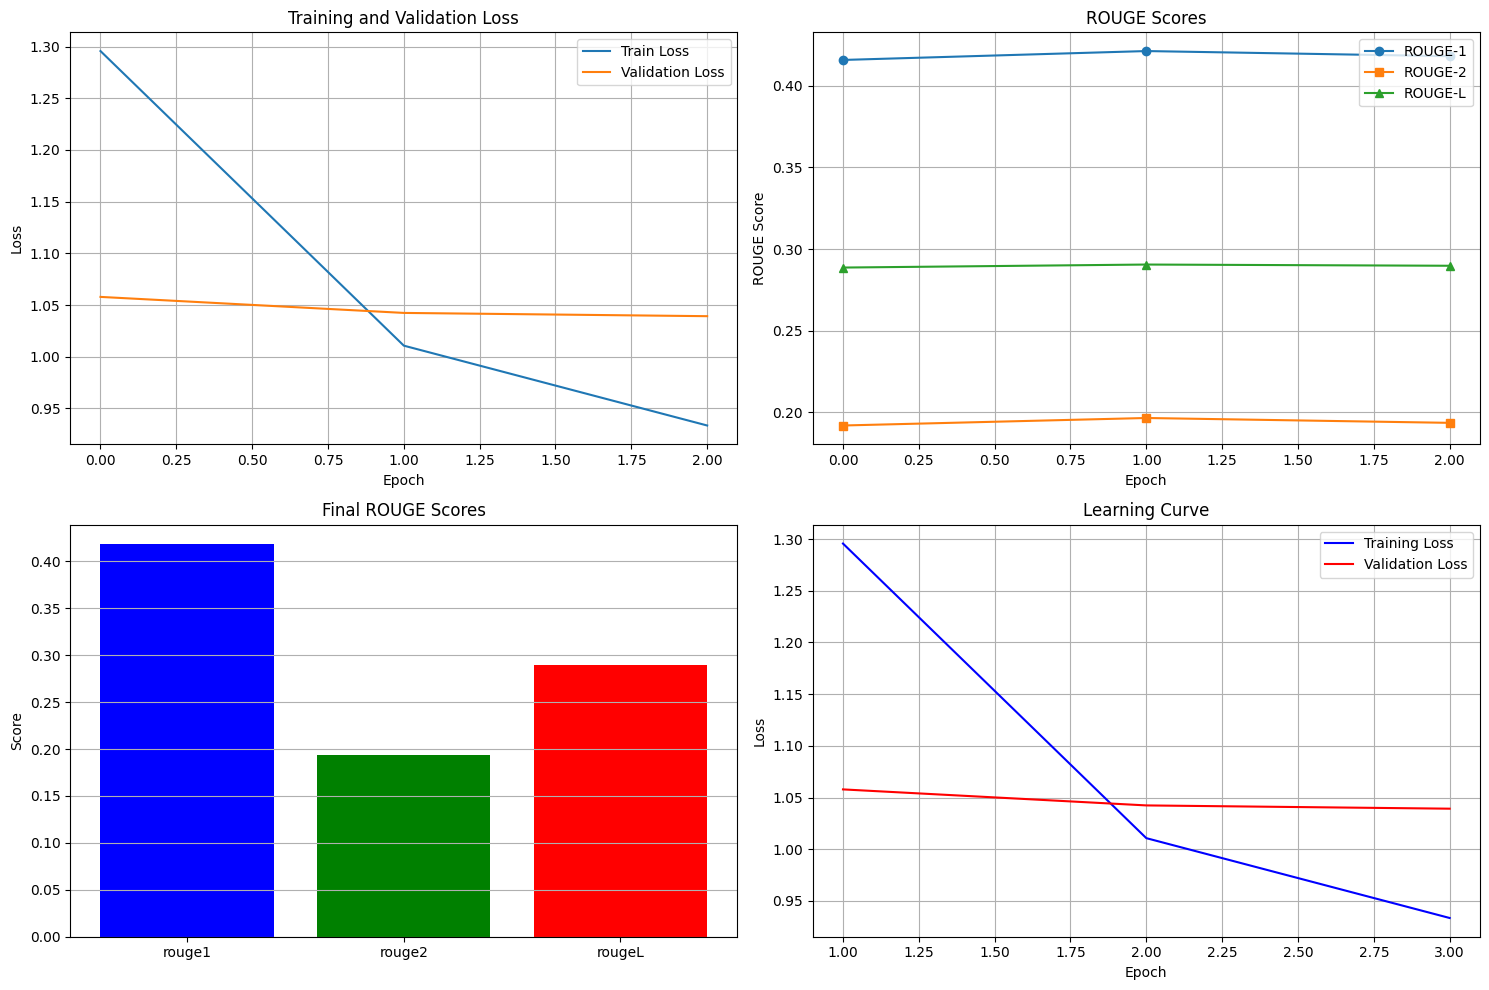

In [45]:
print("\nPlotting training history...")
plot_training_history(train_losses, val_losses, rouge_scores_history)

**Test evaluation**

In [46]:
print("\nPerforming final evaluation on test data")
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
test_loss, test_rouge_scores = evaluate_model(model, test_loader, tokenizer, device, rouge_scorer_obj)

print("\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print("\nROUGE Scores:")
for metric, score in test_rouge_scores.items():
    print(f"{metric}: {score:.6f}")

test_results = {
    'test_loss': test_loss,
    'rouge_scores': test_rouge_scores
}


Performing final evaluation on test data


Evaluating: 100%|██████████| 125/125 [02:32<00:00,  1.22s/it]



Final Test Results:
Test Loss: 0.9823

ROUGE Scores:
rouge1: 0.415059
rouge2: 0.191116
rougeL: 0.286591


**Summarization example**

In [47]:
print("\nSummarization Examples:")

test_articles = test_df['article'].values
test_summaries = test_df['summary'].values
sample_indices = [0, 1, 2]

for i in sample_indices:
    article = test_articles[i]
    actual_summary = test_summaries[i]
    generated_summary = generate_summary(model, tokenizer, article, device)
    
    print(f"\n=== Example {i+1} ===")
    print(f"\nOriginal Article (first 200 chars):\n{article[:200]}...")
    print(f"\nActual Summary:\n{actual_summary}")
    print(f"\nGenerated Summary:\n{generated_summary}")
    
    # Calculate ROUGE scores
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = rouge_scorer_obj.score(actual_summary, generated_summary)
    
    print("\nROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2: {scores['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L: {scores['rougeL'].fmeasure:.4f}")
    print("="*50)


Summarization Examples:

=== Example 1 ===

Original Article (first 200 chars):
David Rylance has been jailed for stealing more than £50,000 from his dying mother, who was suffering from Alzheimer's . A trusted son has been jailed for stealing more than £50,000 from his dying mot...

Actual Summary:
David Rylance, 47, stole thousands of pounds from his own dying mother . Dying pensioner Margaret Rylance was suffering from Alzheimer's disease . She noticed money was missing but concerns were put down to condition . Her son was jailed for two years and three months for stealing £52,000 .

Generated Summary:
David Rylance, 47, admitted theft and fraud involving £52,000 . He was in charge of an appointee account set up at Lloyds Bank . He would transfer large sums of cash from the account into his own, which he used for online gambling .

ROUGE Scores:
ROUGE-1: 0.2667
ROUGE-2: 0.0909
ROUGE-L: 0.1778

=== Example 2 ===

Original Article (first 200 chars):
Aston Villa Cup hero Jack Grealish

### **BART LARGE**

**Data loader and model creation**

In [48]:
tokenizer_large = BartTokenizer.from_pretrained('facebook/bart-large')
model_large = SummarizationModel('facebook/bart-large')
model_large = model_large.to(device)

train_dataset_large = NewsDataset(
    train_df['article'].values,
    train_df['summary'].values,
    tokenizer_large
)

val_dataset_large = NewsDataset(
    val_df['article'].values,
    val_df['summary'].values,
    tokenizer_large
)

test_dataset_large = NewsDataset(
    test_df['article'].values,
    test_df['summary'].values,
    tokenizer_large
)

train_loader_large = DataLoader(train_dataset_large, batch_size=8, shuffle=True)
val_loader_large = DataLoader(val_dataset_large, batch_size=8, shuffle=False)
test_loader_large = DataLoader(test_dataset_large, batch_size=8, shuffle=False)

**Model training**

In [49]:
print("\nStarting BART-large training process:")
train_losses_large, val_losses_large, rouge_scores_history_large = train_model(
    model_large, 
    train_loader_large, 
    val_loader_large, 
    tokenizer_large, 
    device, 
    num_epochs=3, 
    learning_rate=2e-5 
)

print("\nSaving the BART-large model...")
model_save_path_large = 'best_bart_large_summarization_model.pth'
torch.save({
    'model_state_dict': model_large.state_dict(),
    'tokenizer': tokenizer_large,
    'training_history': {
        'train_losses': train_losses_large,
        'val_losses': val_losses_large,
        'rouge_scores': rouge_scores_history_large
    }
}, model_save_path_large)
print(f"Model saved to {model_save_path_large}")


Starting BART-large training process:

Epoch 1/3


Evaluating: 100%|██████████| 250/250 [04:57<00:00,  1.19s/it]


Train Loss: 1.2243
Val Loss: 0.9108
ROUGE-1: 0.4280
ROUGE-2: 0.1998
ROUGE-L: 0.2935

Epoch 2/3


Evaluating: 100%|██████████| 250/250 [05:10<00:00,  1.24s/it]


Train Loss: 0.8517
Val Loss: 0.8990
ROUGE-1: 0.4319
ROUGE-2: 0.2023
ROUGE-L: 0.2951

Epoch 3/3


Evaluating: 100%|██████████| 250/250 [05:03<00:00,  1.21s/it]


Train Loss: 0.7788
Val Loss: 0.9000
ROUGE-1: 0.4352
ROUGE-2: 0.2055
ROUGE-L: 0.2989

Saving the BART-large model...
Model saved to best_bart_large_summarization_model.pth


**Training data visualization**


Plotting BART-large training history...


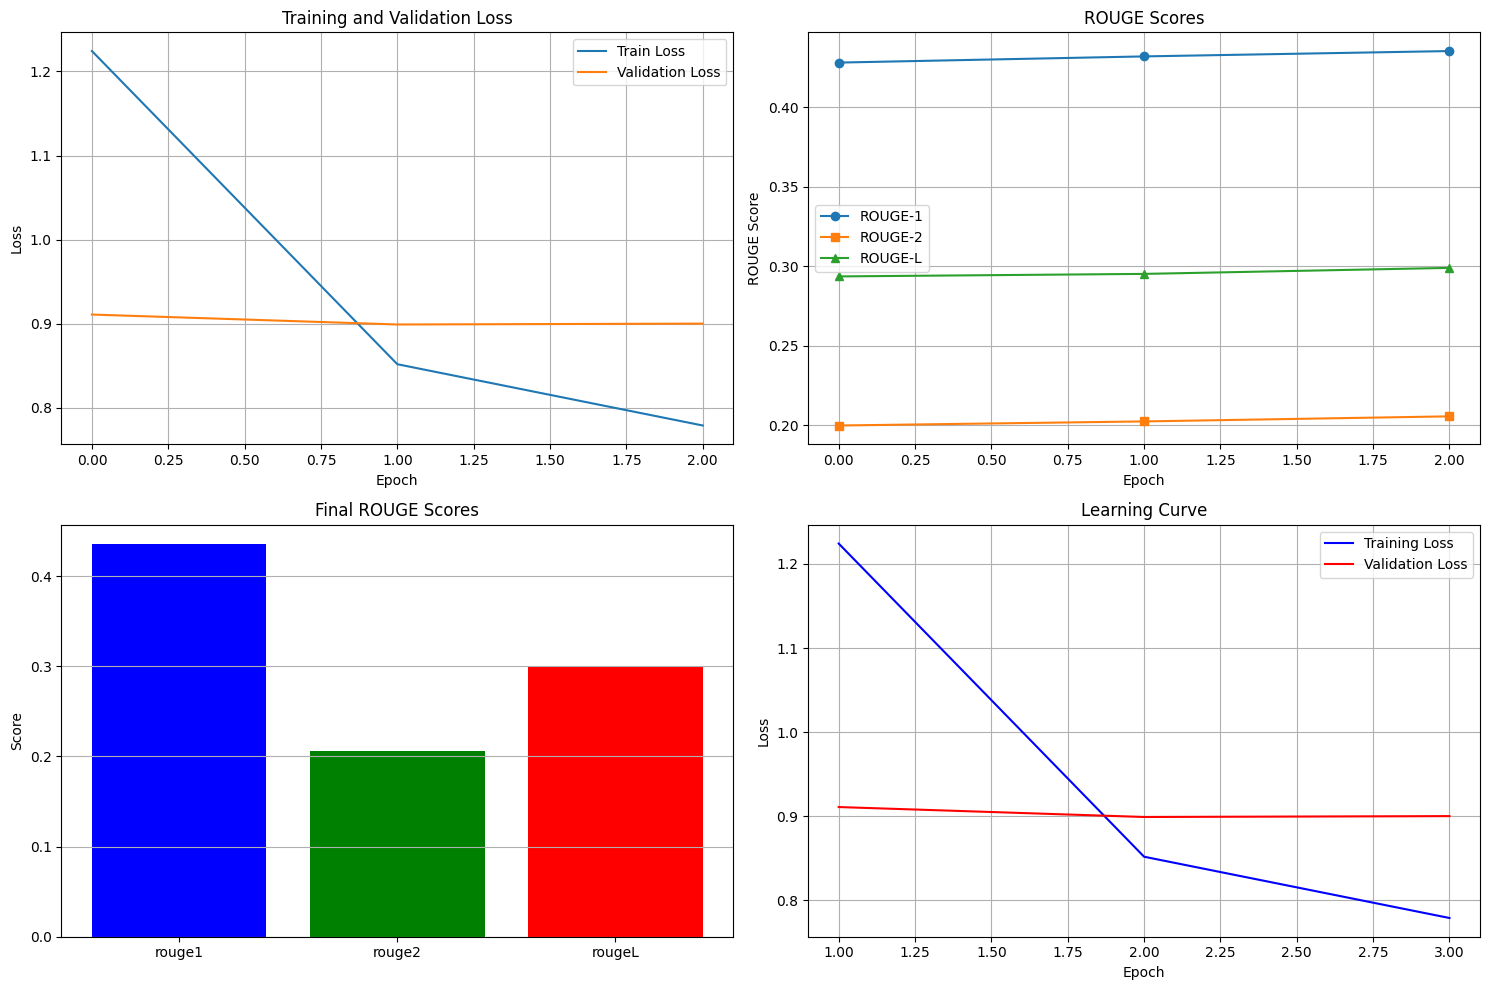

In [50]:
print("\nPlotting BART-large training history...")
plot_training_history(train_losses_large, val_losses_large, rouge_scores_history_large)

In [51]:
print("\nPerforming final evaluation on test data with BART-large")
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
test_loss_large, test_rouge_scores_large = evaluate_model(
    model_large, 
    test_loader_large, 
    tokenizer_large, 
    device, 
    rouge_scorer_obj
)

print("\nFinal Test Results (BART-large):")
print(f"Test Loss: {test_loss_large:.4f}")
print("\nROUGE Scores:")
for metric, score in test_rouge_scores_large.items():
    print(f"{metric}: {score:.6f}")


Performing final evaluation on test data with BART-large


Evaluating: 100%|██████████| 250/250 [05:00<00:00,  1.20s/it]



Final Test Results (BART-large):
Test Loss: 0.8528

ROUGE Scores:
rouge1: 0.431678
rouge2: 0.202680
rougeL: 0.295916


In [52]:
print("\nBART-large Summarization Examples:")
sample_indices = [0, 1, 2]

for i in sample_indices:
    article = test_articles[i]
    actual_summary = test_summaries[i]
    generated_summary = generate_summary(model_large, tokenizer_large, article, device)
    
    print(f"\n=== Example {i+1} ===")
    print(f"\nOriginal Article (first 200 chars):\n{article[:200]}...")
    print(f"\nActual Summary:\n{actual_summary}")
    print(f"\nGenerated Summary (BART-large):\n{generated_summary}")
    
    # Calculate ROUGE scores
    scores = rouge_scorer_obj.score(actual_summary, generated_summary)
    
    print("\nROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2: {scores['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L: {scores['rougeL'].fmeasure:.4f}")
    print("="*50)


BART-large Summarization Examples:

=== Example 1 ===

Original Article (first 200 chars):
David Rylance has been jailed for stealing more than £50,000 from his dying mother, who was suffering from Alzheimer's . A trusted son has been jailed for stealing more than £50,000 from his dying mot...

Actual Summary:
David Rylance, 47, stole thousands of pounds from his own dying mother . Dying pensioner Margaret Rylance was suffering from Alzheimer's disease . She noticed money was missing but concerns were put down to condition . Her son was jailed for two years and three months for stealing £52,000 .

Generated Summary (BART-large):
David Rylance, 47, was in charge of an appointee account set up at Lloyds Bank, which held his mother's cash after her Alzheimer's diagnosis in 2009 . He would transfer large sums of cash from the account into his own, which he used for online gambling . A £13,000 fee to move his mother, from South Shields, into a care home in January 2013 had to be paid by th

**BASE vs LARGE model result comparison**

In [53]:
print("\nModel Comparison - Test Results:")
print("\nBART-base vs BART-large")
print("-" * 40)
print(f"Test Loss - Base: {test_loss:.4f} | Large: {test_loss_large:.4f}")
for metric in test_rouge_scores:
    print(f"{metric} - Base: {test_rouge_scores[metric]:.4f} | Large: {test_rouge_scores_large[metric]:.4f}")


Model Comparison - Test Results:

BART-base vs BART-large
----------------------------------------
Test Loss - Base: 0.9823 | Large: 0.8528
rouge1 - Base: 0.4151 | Large: 0.4317
rouge2 - Base: 0.1911 | Large: 0.2027
rougeL - Base: 0.2866 | Large: 0.2959
